# Optimización de portfolio

Primero instalamos vía pip la librería `yfinance`, que no está disponible en Google Colab, y es una herramienta que permite descargar y manipular datos financieros de Yahoo Finance. Con esta librería se pueden obtener precios históricos de acciones, índices, criptomonedas, bonos, etc. y realizar análisis técnicos, como gráficos, media móvil, volatilidad, entre otros. Además, también se pueden descargar información sobre dividendos y splits de acciones.

In [1]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import datetime
from typing import List

import pandas as pd
import numpy as np
import yfinance as yf
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import matplotlib as mpl

# configure matplotlib
%config InlineBackend.figure_format='retina'
mpl.rcParams["figure.figsize"] = (15, 10)
plt.style.use("seaborn-whitegrid")

symbols = [
    "TSM", 
    "TSLA", 
    "MTN", 
    "IDXX", 
    "FIGS"
]

start_date = datetime.date(2022, 1, 1)

Aquí hemos definido algunos imports, configuraciones y variables que utilizaremos en el resto del notebook.

- `datetime` se utiliza para trabajar con fechas y horas.
- `scipy.optimize.minimize` es una función de la biblioteca Scipy para minimizar una función dada.

La variable `symbols` contiene una lista de códigos de acciones (símbolos) para varias compañías tecnológicas populares. Finalmente, `start_date` es un objeto de tipo `datetime.date` que representa la primera fecha a partir de la cual vamos a traer datos. 

In [3]:
def generate_stocks(symbols: List[str], start: datetime.date): 
    stocks = yf.download(
        symbols, 
        start=start, 
        end=datetime.datetime.today(), 
        progress=False
    )['Close']
    return stocks

def get_returns(stocks: pd.DataFrame):
    returns = np.log(stocks / stocks.shift(1)).dropna(how="any")
    return returns

def generate_weights(n: int, equal: bool=None):
    if equal: 
        w = np.ones(n) / n
        return w
    w = np.random.rand(n)
    w_norm = w / w.sum()
    return w_norm

def get_portfolio_return(w: np.array, returns: pd.DataFrame):
    return np.sum(returns.mean()*w)

def get_risk(w: np.array, returns: pd.DataFrame): 
    return np.sqrt(w.T@returns.cov()@w)

Veamos lo que hacen cada una de estas funciones:

- `generate_stocks`: esta función toma una lista de símbolos de acciones y una fecha inicial y descarga los datos de cierre de Yahoo Finance para esas acciones. Utiliza el método `yf.download()` para descargar los datos y el parámetro `progress=False` para evitar la impresión de mensajes de progreso. La función devuelve solo la columna 'Close' de los datos descargados.

- `get_returns`: esta función toma un DataFrame de acciones y calcula los retornos diarios utilizando la fórmula logarítmica de retorno. Utiliza el método `np.log()` para calcular los retornos y el método `dropna()` para eliminar las filas con valores faltantes. La función devuelve el DataFrame de retornos.

- `generate_weight`: esta función genera pesos aleatorios para cada acción, recibe como argumento el número de acciones a considerar. Utiliza la función `np.random.rand()` para generar los pesos aleatorios y luego normaliza los pesos dividiéndolos entre la suma total de los pesos. La función devuelve el DataFrame de pesos normalizados. Si `equal` es `True`, entonces todos los pesos son el mismo.

- `get_portfolio_return`: esta función toma un array de pesos y un DataFrame de retornos y calcula el retorno diario esperado. Utiliza el método `mean()` de Pandas para calcular los retornos medios de cada acción y luego los multiplica por los pesos correspondientes. La función devuelve el retorno diario esperado. 

- `get_risk`: esta función toma un array de pesos y un DataFrame de retornos y calcula el riesgo asociado a esos pesos. Utiliza el método `cov()` de Pandas para calcular la matriz de covarianza de los retornos y luego multiplica la matriz de covarianza por los pesos. La función devuelve el riesgo calculado. Si $w$ es el vector de pesos y $\Omega = (\sigma)_{ij}$ la [matriz de covarianza](https://en.wikipedia.org/wiki/Covariance_matrix) de retornos, el riesgo se calcula como 

$$
\text{riesgo} = \sqrt{w^T \Omega w} = \sqrt{\sum_{i=1}^{n} \sum_{j=1}^n w_iw_j\sigma_{ij}}
$$

In [4]:
stocks = generate_stocks(symbols, start_date)
returns = get_returns(stocks)

Podemos utilizar `pandas` directamente para representar las series, llamando al método `plot` de la clase `pd.DataFrame`. 

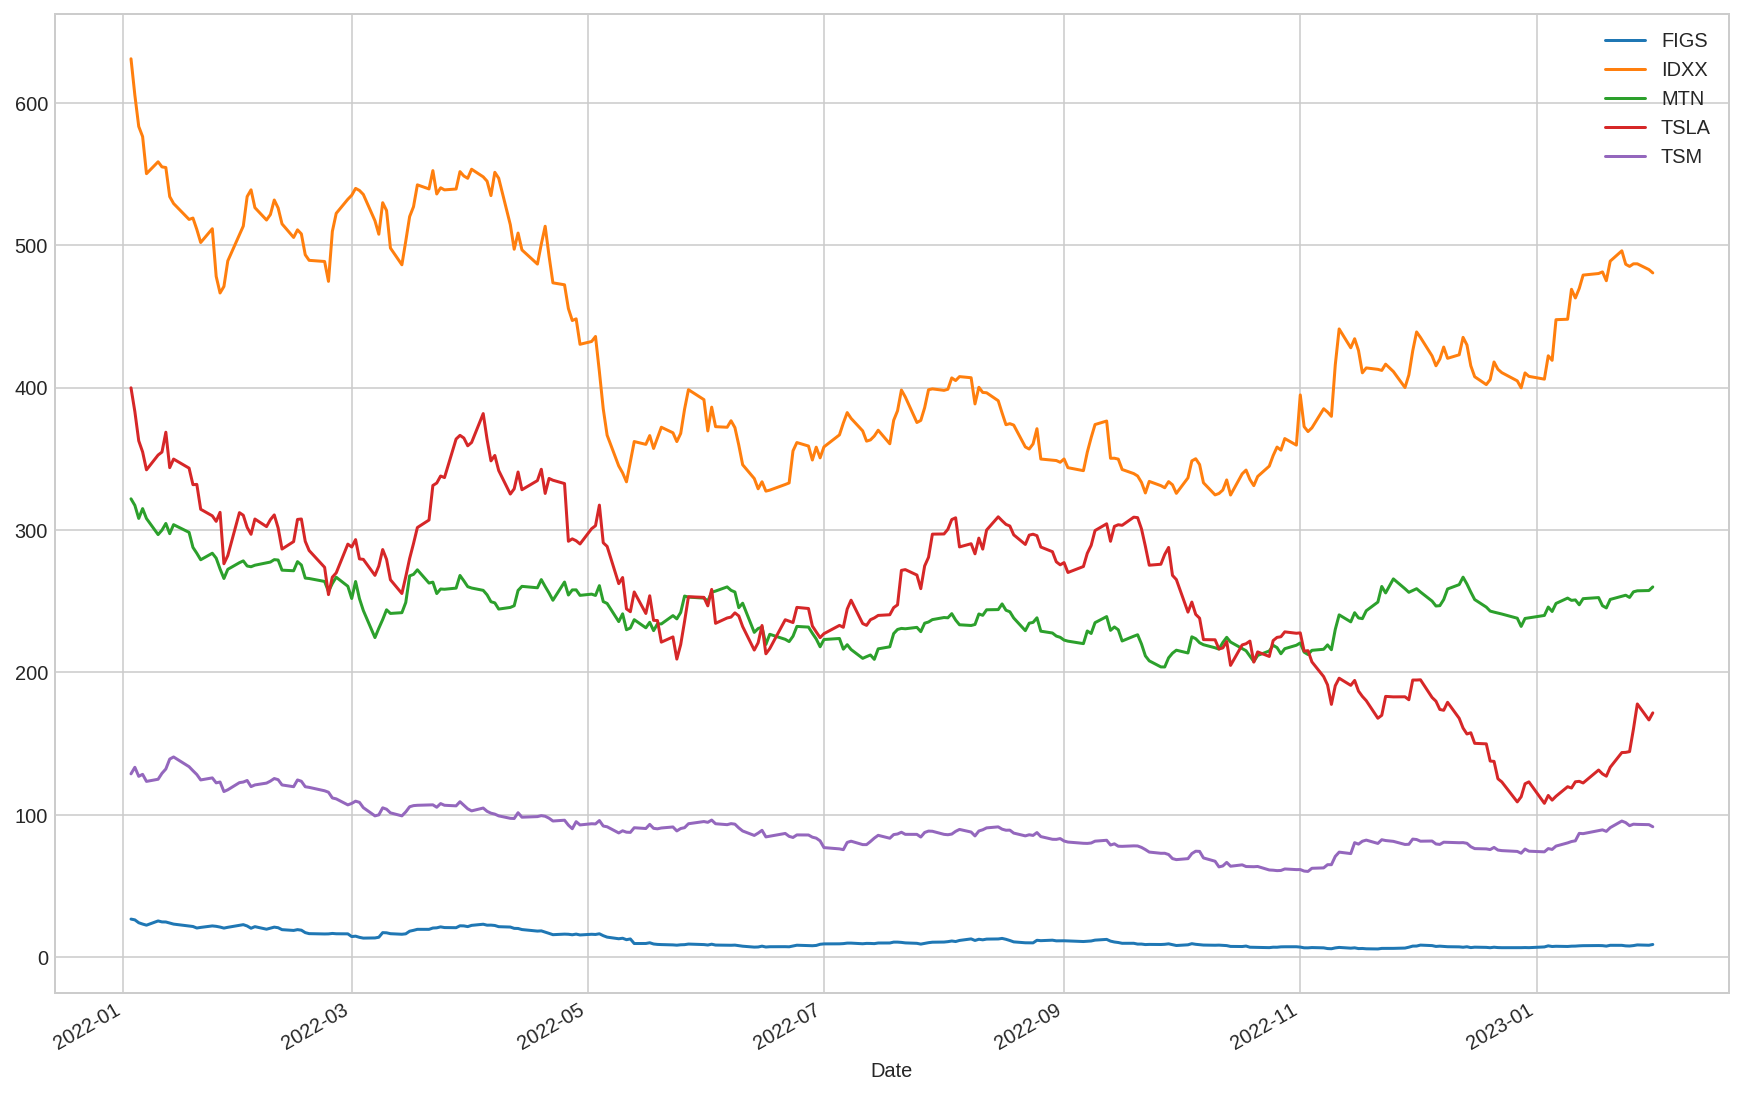

In [5]:
stocks.plot()

Representamos ahora la serie de retornos y los correspondientes histogramas 

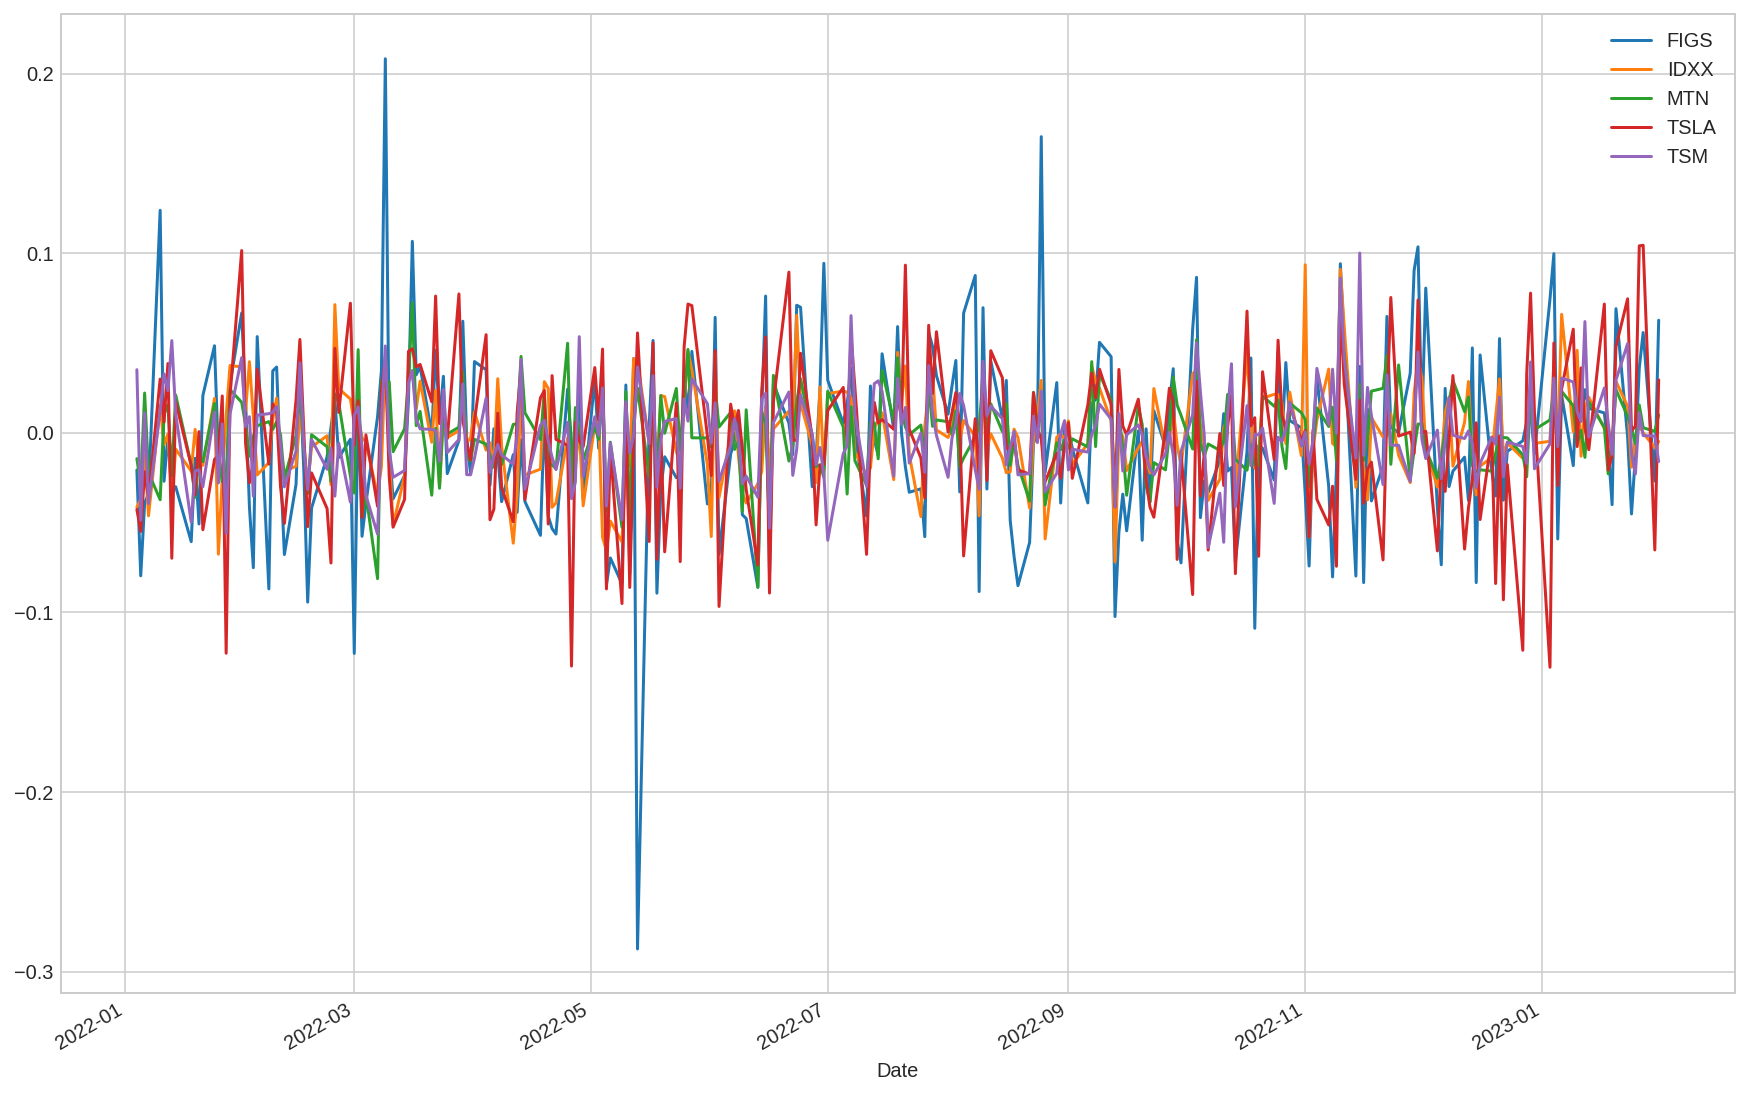

In [6]:
returns.plot()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f519523d760>,
      dtype=object)

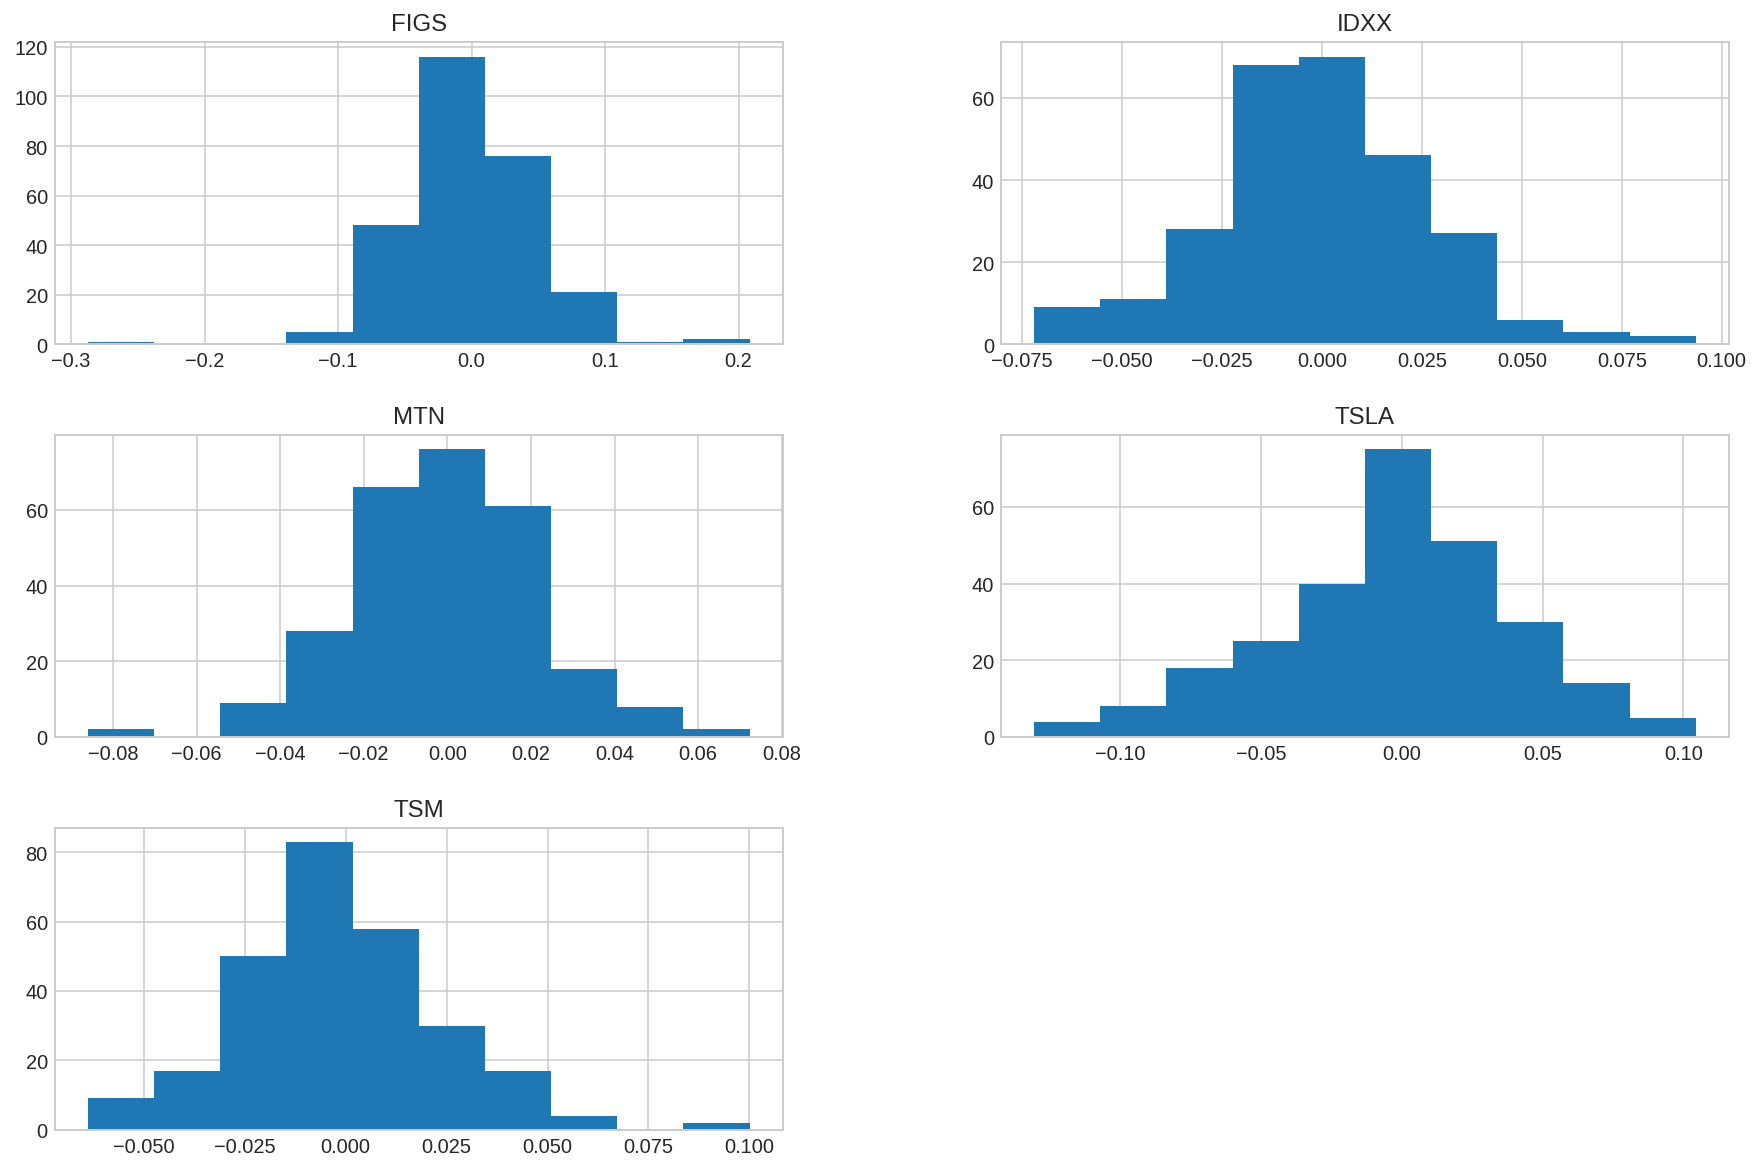

In [7]:
returns.hist()

## Buscamos un vector de pesos óptimo que minimice el riesgo

In [8]:
def get_optimal_portfolio_weights(returns):
    # The constraints
    cons = (
        {
            "type": "eq", 
            "fun": lambda w: np.sum(w) - 1
        }, 
        {
            "type": "ineq", 
            "fun": lambda w: np.sum(returns.mean()*w) - returns.mean().mean()
        }
    ) 
    
    
    # Every stock can get any weight from 0 to 1
    bounds = tuple((0,1) for x in range(returns.shape[1])) 
    
    # Initialize the weights with an even split
    # In out case each stock will have 10% at the beginning
    guess = [1./returns.shape[1] for x in range(returns.shape[1])]
    
    objective = lambda w: get_risk(w, returns) 

    optimized_results = minimize(objective, guess, method = "SLSQP", bounds=bounds, constraints=cons)

    s = pd.Series(
        optimized_results.x, 
        index=returns.columns
    )

    print("Vector de pesos óptimo")
    print(s)
    print(s.sum())

    return s

## Visualizaciones

In [9]:
def generate_plot(ax, returns, n, w_opt):

    # individual stocks
    individual_returns = returns.mean()
    individual_risks = returns.std()
    
    # random portfolios
    portfolio_returns = []
    portfolio_risks = []
    for _ in range(n):
        w = generate_weights(returns.shape[1])
        portfolio_returns.append(get_portfolio_return(w, returns))
        portfolio_risks.append(get_risk(w, returns))

    # equally distributed portfolio
    w_eq = generate_weights(returns.shape[1], equal=True)
    eq_portfolio_returns = get_portfolio_return(w_eq, returns)
    eq_portfolio_risk = get_risk(w_eq, returns)

    # optimal portfolio
    opt_portfolio_returns = get_portfolio_return(w_opt, returns)
    opt_portfolio_risk = get_risk(w_opt, returns)

    ax.scatter(individual_returns, individual_risks, label="individual stocks", s=50)
    for i, col in enumerate(returns.columns):
        ax.annotate(col, (individual_returns[i], individual_risks[i]))
    ax.scatter(portfolio_returns, portfolio_risks, label="random portfolio", s=100)
    ax.scatter(eq_portfolio_returns, eq_portfolio_risk, label="eq. dist. portfolio", s=100)
    ax.scatter(opt_portfolio_returns, opt_portfolio_risk, label="optimal portfolio", s=200)

    ax.legend()
    ax.set_xlabel("Expected daily return")
    ax.set_ylabel("risk")
    ax.set_title("Return vs risk")

    return ax

Vector de pesos óptimo
FIGS    2.327376e-18
IDXX    2.109383e-01
MTN     4.760101e-01
TSLA    0.000000e+00
TSM     3.130515e-01
dtype: float64
1.0


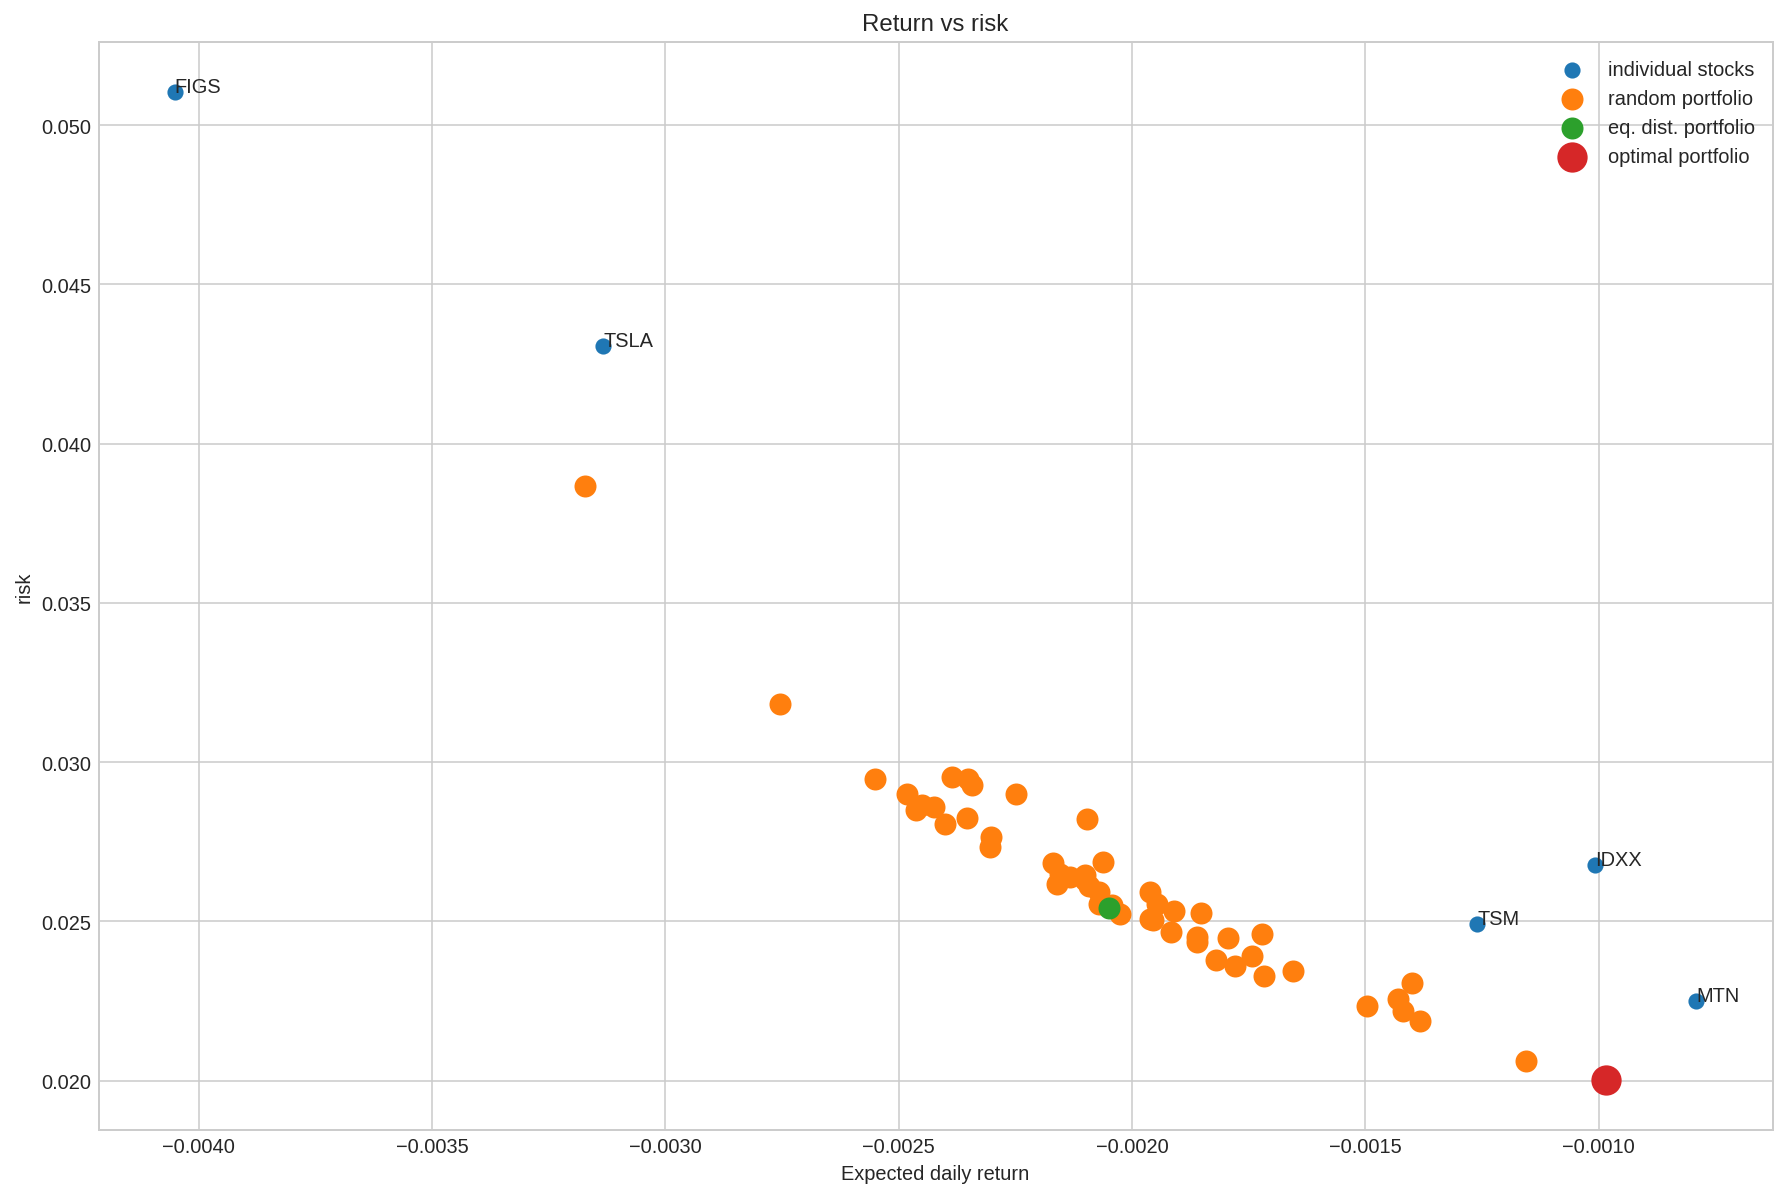

In [10]:
fig, ax = plt.subplots()
w_opt = get_optimal_portfolio_weights(returns)
generate_plot(ax, returns, n=50, w_opt=w_opt)

## Encapsulando todo en una sola clase

In [22]:
import numpy as np
import pandas as pd
import yfinance as yf
from scipy.optimize import minimize
from typing import List
import datetime
import matplotlib as mpl
from matplotlib.axes import Axes
import matplotlib.pyplot as plt

class OptimalPortfolio:
    
    def __init__(
        self, 
        symbols: List[str], 
        start_date: datetime.date = datetime.date.today() - datetime.timedelta(100),
        end_date: datetime.date = datetime.date.today()
    ):
        self.stocks = self.generate_stocks(symbols, start_date, end_date)
        self.returns = self.get_returns(self.stocks)
        self.w_opt = self.get_optimal_portfolio_weights()

    def generate_stocks(self, symbols: List[str], start_date: datetime.date, end_date: datetime.date): 
        stocks = yf.download(
            symbols, 
            start=start_date, 
            end=end_date, 
            progress=False
        )['Close']
        return stocks

    def get_returns(self, stocks: pd.DataFrame):
        returns = np.log(stocks / stocks.shift(1)).dropna(how="any")
        return returns

    def generate_weights(self, n: int, equal: bool = None):
        if equal: 
            w = np.ones(n) / n
            return w
        w = np.random.rand(n)
        w_norm = w / w.sum()
        return w_norm

    def get_portfolio_return(self, w: np.array, returns: pd.DataFrame):
        return np.sum(returns.mean()*w)

    def get_risk(self, w: np.array, returns: pd.DataFrame): 
        return np.sqrt(w.T@returns.cov()@w)

    def get_optimal_portfolio_weights(self):
        # The constraints
        cons = (
            {
                "type": "eq", 
                "fun": lambda w: np.sum(w) - 1
            }, 
            {
                "type": "ineq", 
                "fun": lambda w: np.sum(self.returns.mean()*w) - self.returns.mean().mean()
            }
        ) 

        # Every stock can get any weight from 0 to 1
        bounds = tuple((0,1) for x in range(self.returns.shape[1])) 

        # Initialize the weights with an even split
        # In out case each stock will have 10% at the beginning
        guess = [1./self.returns.shape[1] for x in range(self.returns.shape[1])]

        objective = lambda w: self.get_risk(w, self.returns) 

        optimized_results = minimize(objective, guess, method = "SLSQP", bounds=bounds, constraints=cons)

        w_opt = np.array(optimized_results.x)

        return w_opt

    def generate_plot(self, ax: Axes, n: int = 50):

        # individual stocks
        individual_returns = self.returns.mean()
        individual_risks = self.returns.std()
        
        # random portfolios
        portfolio_returns = []
        portfolio_risks = []
        for _ in range(n):
            w = self.generate_weights(self.returns.shape[1])
            portfolio_returns.append(self.get_portfolio_return(w, self.returns))
            portfolio_risks.append(self.get_risk(w, self.returns))

        # equally distributed portfolio
        w_eq = self.generate_weights(self.returns.shape[1], equal=True)
        eq_portfolio_returns = self.get_portfolio_return(w_eq, self.returns)
        eq_portfolio_risk = self.get_risk(w_eq, self.returns)

        # optimal portfolio
        opt_portfolio_returns = self.get_portfolio_return(self.w_opt, self.returns)
        opt_portfolio_risk = self.get_risk(self.w_opt, self.returns)

        ax.scatter(individual_returns, individual_risks, label="individual stocks", s=50)
        for i, col in enumerate(self.returns.columns):
            ax.annotate(col, (individual_returns[i], individual_risks[i]))
        ax.scatter(portfolio_returns, portfolio_risks, label="random portfolio", s=100)
        ax.scatter(eq_portfolio_returns, eq_portfolio_risk, label="eq. dist. portfolio", s=100)
        ax.scatter(opt_portfolio_returns, opt_portfolio_risk, label="optimal portfolio", s=200)

        ax.legend()
        ax.set_xlabel("Expected daily return")
        ax.set_ylabel("risk")
        ax.set_title("Return vs risk")

        return ax


In [23]:
optimal_portfolio = OptimalPortfolio(
    [
        "AAPL", 
        "MSFT", 
        "TSLA", 
        "NVDA", 
        "AMZN", 
        "JNJ", 
        "V"
    ]
)

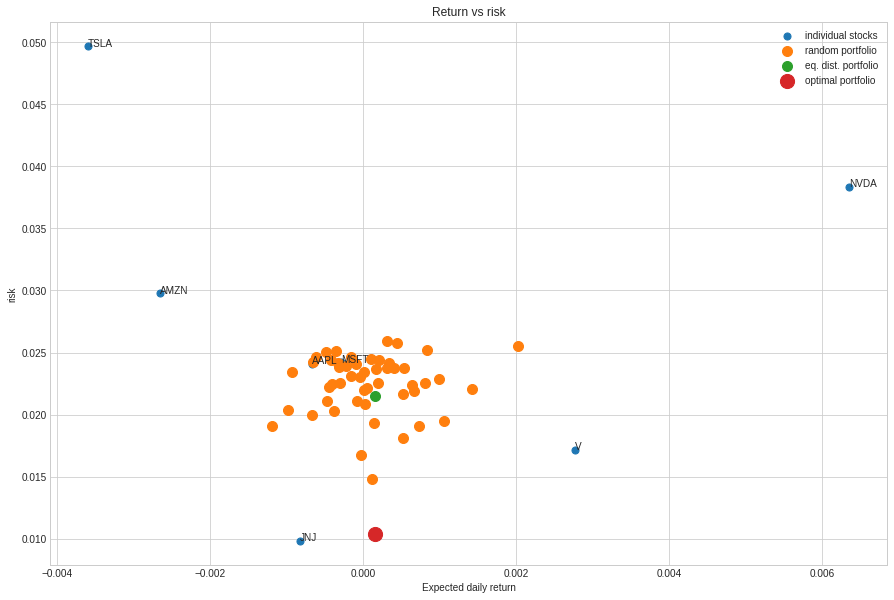

In [25]:
mpl.rcParams["figure.figsize"] = (15, 10)
plt.style.use("seaborn-whitegrid")

fig, ax = plt.subplots()
optimal_portfolio.generate_plot(ax)